In [1]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Pm")



library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations
library(nullranges)
genome_bs <- BSgenome.Pm


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.1     
✔ ggplot2   3.4.4          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘devtools’ was built under R version 4.3.1”
Loading required package: usethis



ℹ Loading BSgenome.Pm
Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




In [2]:

## Load Markers for All Species
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Pm.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species) 


Rows: 52 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
### Load Motifs for Analysis
core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)
all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}


### Update the Names to be the actual IDs, as well as convert to PWM matrix List (Nasty as fuck)
library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)


#Generate an Index Annotation name for later usage. Will be used because we need to rip these to annotate the Granges objects
#later
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}

# Example usage:
# Assuming your PWMatrixList object is named pwMatrixListObject
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




In [4]:
#sb_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/sb_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
pm_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/pm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#zm_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/zm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#uf_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/uf_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#os_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/os_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))



Rows: 65990 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, acr_id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
header_bed <- c('chr','start','end','id','score')
zm_acr_intersections <- read_delim("/home/jpm73279/genome_downloads/C4_markers/conservation/pm.all_intersection_acr.intersection.bed", 
            col_names = header_bed) %>% 
    separate(id, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)

combined_acrs_marker_info <- left_join(zm_acr_intersections, markers, by = c("locus" = "name")) %>% 
    select(acr,acr_cell_type_specific_class, locus, gene_family, type)


Rows: 178 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
GetGC <- function(bsgenome, gr){

  seqs <- BSgenome::getSeq(bsgenome, gr)
  return(as.numeric(Biostrings::letterFrequency(x = seqs, letters = "GC", as.prob = TRUE)))


}

In [10]:
zm_peaks_gr <- GRanges(pm_acrs, seqinfo=seqinfo(genome_bs))
zm_gc_content_acrs <- GetGC(genome_bs, zm_peaks_gr)
zm_peaks_gr$GC <- zm_gc_content_acrs

names(zm_peaks_gr) <- as.character(zm_peaks_gr)
zm_peaks_gr <- unique(zm_peaks_gr)

# get peak sequences, we'll need this later
zm_peak_seqs <- getSeq(genome_bs, zm_peaks_gr) # <2s


# exclude peaks with any N's, to avoid warnings further down
hasNs    <- (alphabetFrequency(zm_peak_seqs)[,"N"]>0)
addmargins(table(hasNs)) # => only drops 5 sequences

zm_peak_seqs <- zm_peak_seqs[!hasNs]
zm_peaks_gr  <- zm_peaks_gr[!hasNs]


hasNs
FALSE  TRUE   Sum 
65987     3 65990 

In [11]:
zm_acrs_TFs <- as_tibble(as.data.frame(zm_peaks_gr)) %>% 
    tidyr::separate(acr_id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    left_join(., combined_acrs_marker_info, by = c("acr", "acr_cell_type_specific_class")) %>% 
    mutate(locus = case_when(is.na(locus) == TRUE ~ "None",
                            TRUE ~ locus),
           gene_family = case_when(is.na(gene_family) == TRUE ~ "None",
                            TRUE ~ gene_family),
           type = case_when(is.na(type) == TRUE ~ "None",
                            TRUE ~ type),
          bool_type = case_when(type == "None" ~ FALSE,
                                type != "None" ~ TRUE)) %>% 
    dplyr::filter((type == "None" &  acr_cell_type_specific_class == "broadly_accessible")| 
                  type != "None" &  acr_cell_type_specific_class %in% c("mesophyll", "bundle_sheath", "broadly_accessible") ) 
                                

In [245]:
## Score Real ACRs Around our regions of interest values 

In [22]:
motif_IDs <- motif_id_index$TF_ID
zm_acrs_c4_regions <- zm_acrs_TFs %>% 
    dplyr::filter(type != "None")

zm_c4_peaks_gr <- GRanges(zm_acrs_c4_regions, seqinfo=seqinfo(genome_bs))

names(zm_c4_peaks_gr) <- as.character(zm_c4_peaks_gr)
zm_c4_peaks_gr <- unique(zm_c4_peaks_gr)

# Get peak sequences
peak_seqs <- getSeq(genome_bs, zm_c4_peaks_gr)

# Exclude peaks with any N's
hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
peak_seqs <- peak_seqs[!hasNs]

# Run matchMotifs
system.time(
    c4_motif_matches <- matchMotifs(
    pw_matrix_list_converted, 
    zm_c4_peaks_gr, 
    genome = genome_bs,  
    p.cutoff = .001, # using a stringent p-value
    out="positions"
    ))

assign_motif_ids_intersect_regions <- function(granges_list, zm_c4_peaks_gr, motif_IDs) {
    for (i in seq_along(granges_list)) {
        # Assign motif IDs to each GRanges element
        granges_list[[i]]$TF_ID <- motif_IDs[i]
        
        # Find overlaps with the provided peaks GRanges
        overlaps <- findOverlaps(granges_list[[i]], zm_c4_peaks_gr)
        
        # Extract and annotate acr values based on overlaps
        ids <- zm_c4_peaks_gr$acr[subjectHits(overlaps)]
        granges_list[[i]]$acr <- ids[queryHits(overlaps)]
    }
    
    return(granges_list)
}

granges_list_c4 <- assign_motif_ids_intersect_regions(c4_motif_matches,
                                                      zm_c4_peaks_gr, 
                                                      motif_IDs)

# Convert to tibble and join with null_samples
zm_acrs_TFs_c4_prescence <- as_tibble((granges_list_c4)) %>% 
    left_join(., as_tibble(zm_c4_peaks_gr), by = c("acr"))

    # Count numbers
real_count_numer <- zm_acrs_TFs_c4_prescence %>% 
        dplyr::group_by(TF_ID, type, locus) %>% 
        summarise(counts = n()) %>% 
        dplyr::ungroup() %>% 
    mutate(sample = "real")

   user  system elapsed 
  0.547   0.002   0.552 

`summarise()` has grouped output by 'TF_ID', 'type'. You can override using the
`.groups` argument.


In [38]:
generate_bootstrap_analysis_per_gene_parallel <- function(acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        BSgenome.B73, 
                                        filter_type, 
                                        filter_value, covariate = ~GC, 
                                        p_cutoff = .001, 
                                        num_bootstraps = 10) {
    results_per_gene <- list()
    
    unique_loci <- unique(acrs_all$locus)
    gene_models <- unique_loci[unique_loci != "None"]

#    for(gene_model in gene_models) {
#        null_indices_list <- vector("list", num_bootstraps) 
    
       results_per_gene <- future_map(gene_models, function(gene_model) {
        null_indices_list <- vector("list", num_bootstraps)

        for(bootstrap_iter in 1:num_bootstraps) {
            # Apply dynamic filtering based on passed arguments
            focal_filter <- acrs_all$locus == gene_model


        # Generate null_samples
        null_samples <- matchRanges(focal = acrs_all[acrs_all$locus == gene_model, ], 
                                    pool = acrs_all[!acrs_all$bool_type, ],
                                    covar = covariate)

        # Process the null_samples
        null_samples <- unique(null_samples)
        peak_seqs <- getSeq(BSgenome.B73, null_samples)
        hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
        peak_seqs <- peak_seqs[!hasNs]

        # Run matchMotifs
        system.time({
            motif_matches <- matchMotifs(
                pw_matrix_list_converted, 
                null_samples, 
                genome = BSgenome.B73, 
                p.cutoff = p_cutoff, 
                out = "positions"
            )
        })

        # Annotate and process GRanges list
        motif_IDs <- motif_id_index$TF_ID
        granges_list <- motif_matches
        for (i in seq_along(granges_list)) {
            if(length(granges_list[[i]]) > 0) {
            granges_list[[i]]$TF_ID <- motif_IDs[i]
        
            overlaps <- findOverlaps(granges_list[[i]], null_samples)
            ids <- null_samples$acr[subjectHits(overlaps)]
            granges_list[[i]]$acr <- ids[queryHits(overlaps)]
            }
        }


        # Convert to tibble and perform join and count operations
        acrs_TFs <- as_tibble(granges_list) %>% 
            left_join(., as_tibble(null_samples), by = c("acr"))

        count_numer <- acrs_TFs %>% 
            dplyr::group_by(TF_ID, type) %>% 
            summarise(counts = n()) %>% 
            dplyr::ungroup()
        
            null_indices_list[[bootstrap_iter]] <- count_numer
        }
        return(null_indices_list)
    #results_per_gene[[gene_model]] <- null_indices_list
    }, .progress = TRUE)
    
    names(results_per_gene) <- gene_models
    return(results_per_gene)
#return(results_per_gene)
}

In [40]:
library(furrr)
plan(multisession, workers = 8)

Loading required package: future



In [ ]:

zm_acrs_all <- GRanges(zm_acrs_TFs, seqinfo=seqinfo(genome_bs))
generate_null_values_gene_models <- generate_bootstrap_analysis_per_gene_parallel(zm_acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        genome_bs, 
                                        "mesophyll", 
                                        filter_value, 
                                        covariate = ~GC, 
                                        p_cutoff = .001, 
                                       num_bootstraps = 2000)

# Per Gene Model Motif Analysis

In [ ]:
head(enzyme_family_class)

In [ ]:

enzyme_family_class <- data.frame(gene_family=c("AlaAT", "AspAT", "CA", "DIC", "DIT", "NADMDH", "NADME", "NADPMDH", "NADPME", "NHD", "PEPCK", "PEPC", "PPDKRP", "PPDK", "PPT", "RBCS", "RCA", "BASS"),
                                  enzyme_class=c("variable", "variable", "core", "core", "variable", "variable", "variable", "variable", "variable", "variable", "core", "core", "core", "core", "core", "core", "core", "variable"))


In [ ]:
per_loci_values <- generate_null_values_gene_models

combined_df_models <- imap_dfr(per_loci_values, ~map_df(.x, ~.x %>% 
                                            mutate(inner_index = row_number()), 
                                            .id = "nested_index") %>% 
                        mutate(locus = .y))


In [ ]:
plot_real_counts <- real_count_numer


In [ ]:
nested_null_values <- combined_df_models %>% 
    dplyr::select(-inner_index) %>% 
    group_by(locus, TF_ID) %>% 
    nest()

combined_real_null <- left_join(real_count_numer, nested_null_values, by = c("locus", "TF_ID"))

In [ ]:
pvals <- combined_real_null %>% 
    dplyr::rename(real_counts = counts) %>% 
    dplyr::rowwise() %>% 
    dplyr::mutate(passing_val = sum(data$counts > real_counts) + 1,
                  length_null = length(data$counts) + 1,
                 pval = passing_val/length_null )


saveRDS(pvals, 
        file = "/home/jpm73279/genome_downloads/C4_markers/shuffled_null_dist_storage/Pm.shuffled_null_dist.rds")
        

In [ ]:
pvals %>% 
    dplyr::filter(pval < .05) %>% 
    dplyr::select(-data)

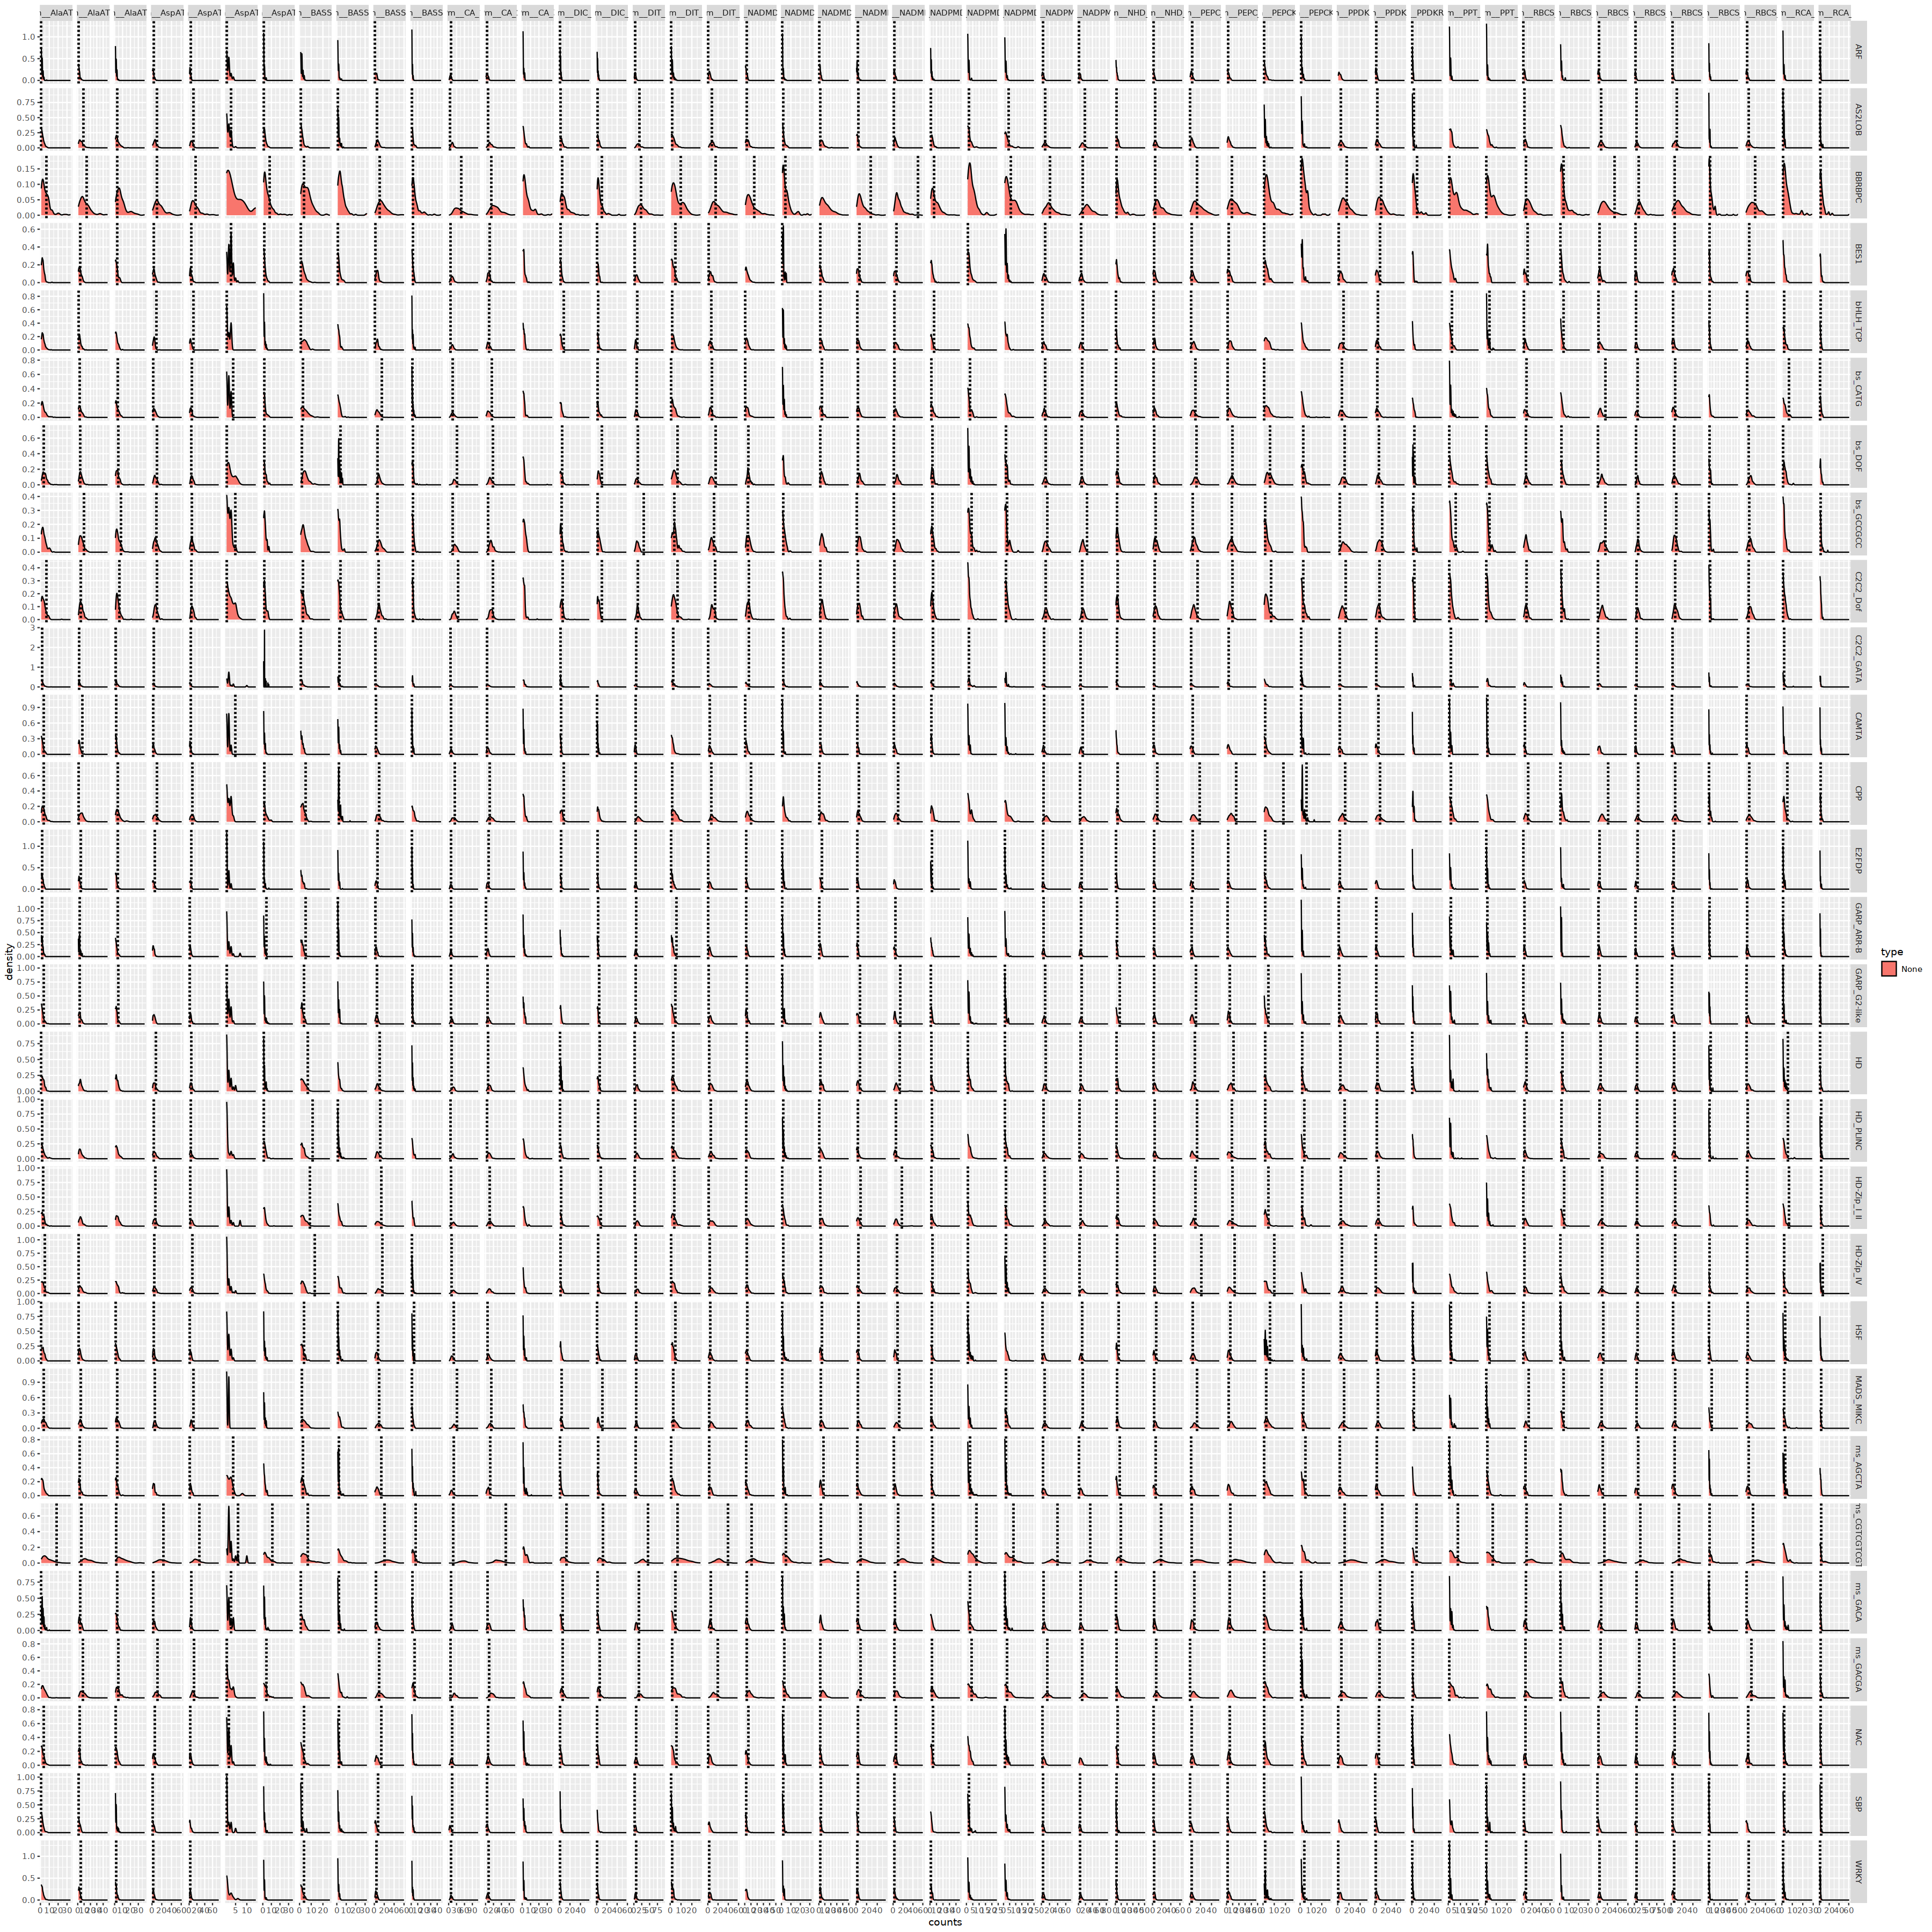

In [30]:
plot_real_counts <- real_count_numer %>% 
    dplyr::filter(locus %in% combined_df_models$locus)


options(repr.plot.width=30, repr.plot.height=30)

combined_df_models %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~locus,   scales = "free") +
    geom_vline(data = plot_real_counts, 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)


In [35]:
combined_df_models_split <- combined_df_models %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)


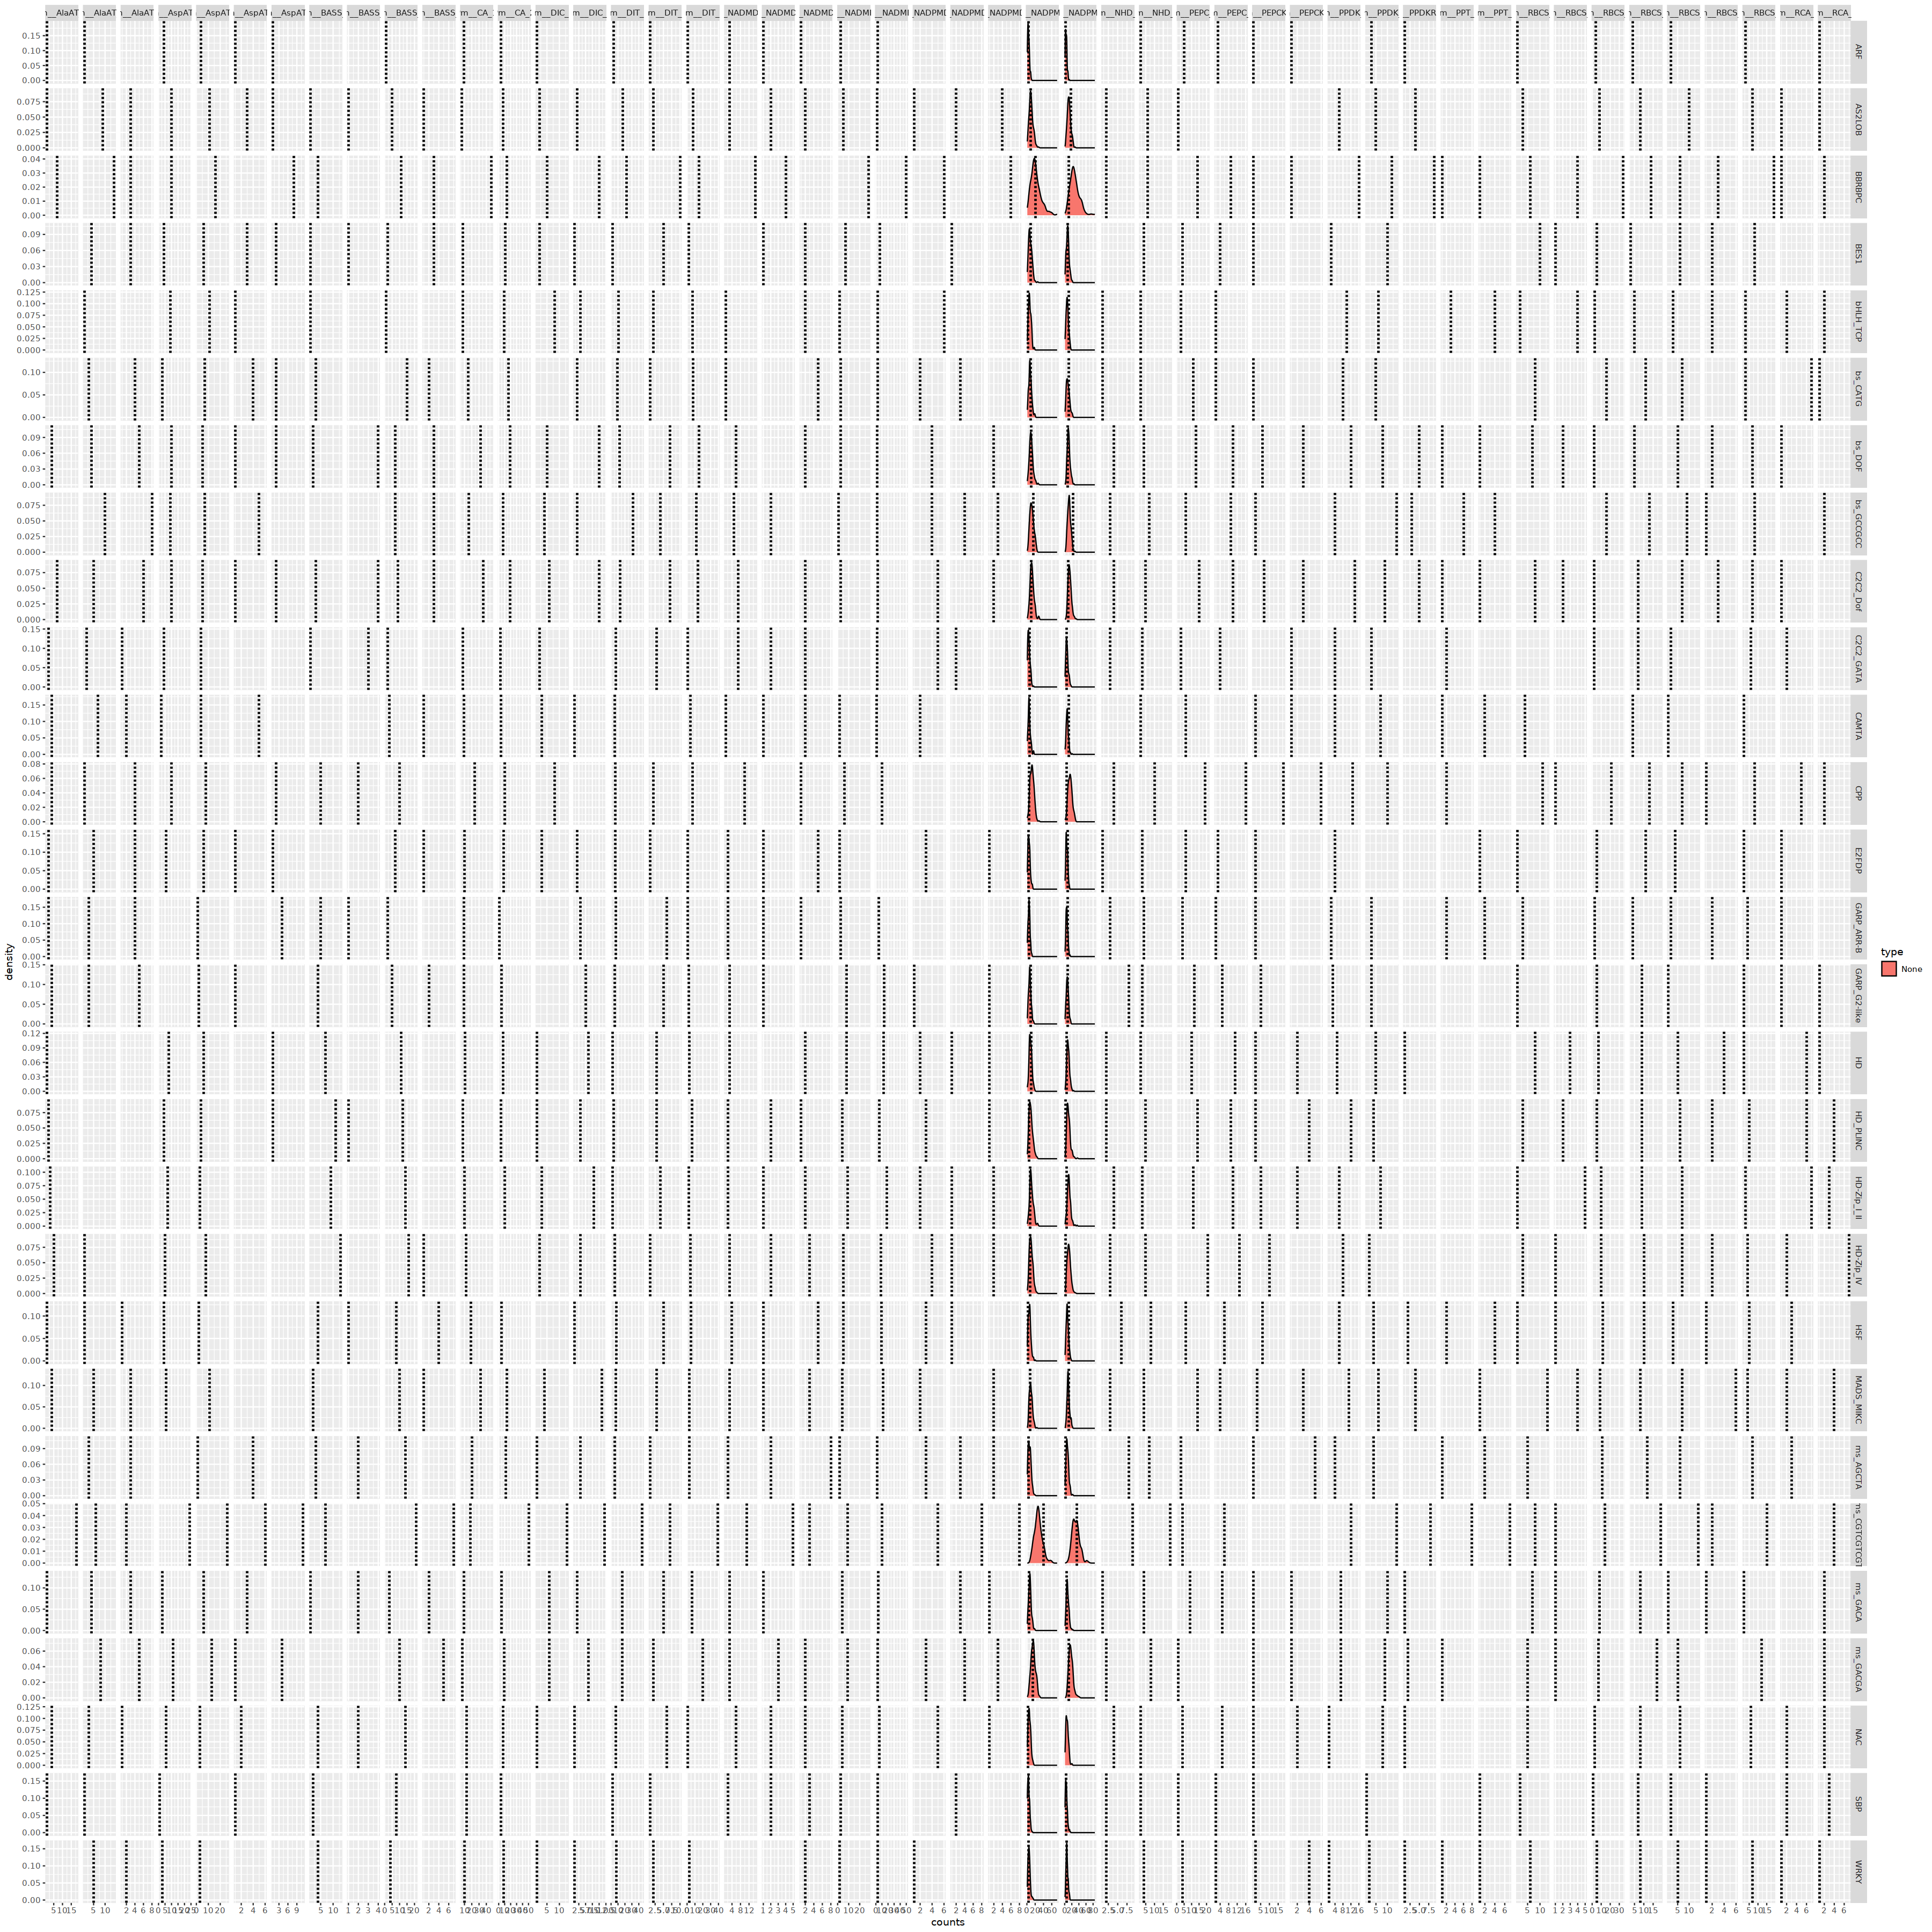

In [37]:

combined_df_models_split %>% 
    dplyr::filter(gene_family == "NADPME") %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~locus,   scales = "free") +
    geom_vline(data = plot_real_counts %>%  , 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)
